# PK file containing 33 columns

In [237]:
import numpy as np
import matplotlib.pyplot as plt

camb = np.genfromtxt('./camb_regpt/planck18_matterpower.dat')

from scipy.interpolate import interp1d
import itertools

kk = np.linspace(0.001,0.15,100)

k = camb[:,0]

pb2d_0 = camb[:,5]
pb2d = interp1d(k,pb2d_0,kind='nearest')


pb2v_0 = camb[:,6]
pb2v = interp1d(k,pb2v_0,kind='nearest')


pb22_0 = camb[:,7]
pb22 = interp1d(k,pb22_0,kind='nearest')


pbs2d_0 = camb[:,8]
pbs2d = interp1d(k,pbs2d_0,kind='nearest')


pbs2v_0 = camb[:,9]
pbs2v = interp1d(k,pbs2v_0,kind='nearest')


pb2s2_0 = camb[:,10]
pb2s2 = interp1d(k,pb2s2_0,kind='nearest')


pbs22_0 = camb[:,11]
pbs22 = interp1d(k,pbs22_0,kind='nearest')


pb3nl_0 = camb[:,12]
pb3nl = interp1d(k,pb3nl_0,kind='nearest')


A = np.full((3,3),None)
A0 = np.full((3,3),None)
A0[0,0],A0[0,1],A0[1,1],A0[1,2],A0[2,2] = camb[:,16:21].T
for m,n in itertools.product(range(3),range(3)):
    if A0[m,n] is not None:
        A[m,n] = interp1d(k,A0[m,n],kind='nearest')
       
        
B0 = np.full((4,4,4),None)
B = np.full((4,4,4),None)
B0[0,0,0],B0[0,0,1],B0[0,1,0],B0[0,1,1],\
B0[1,0,0],B0[1,0,1],B0[1,1,0],B0[1,1,1],\
B0[2,0,1],B0[2,1,0],B0[2,1,1],B0[3,1,1] = camb[:,21:33].T
for m,a,b in itertools.product(range(4),range(2),range(2)):
    if B0[m,a,b] is not None:
        B[m,a,b] = interp1d(k,B0[m,a,b],kind='nearest')
        

# Pdd,Pdv,Pvv from RegPT

In [238]:
k11,_,_,pdd_0,_ = np.genfromtxt('./camb_regpt/p11.dat').T
pdd = interp1d(k11,pdd_0,kind='nearest')


k12,_,_,pdv_0,_ = np.genfromtxt('./camb_regpt/p12.dat').T
pdv = interp1d(k12,pdv_0,kind='nearest')


k22,_,_,pvv_0,_ = np.genfromtxt('./camb_regpt/p22.dat').T
pvv = interp1d(k22,pvv_0,kind='nearest')


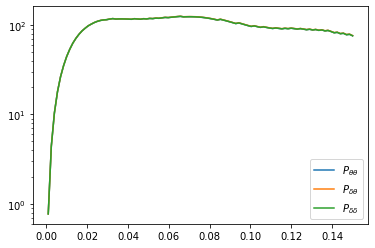

In [239]:
cut = np.where((pvv != pdd) & (pdv != pdd) & (pvv != pdv))
plt.plot(kk,kk*pvv(kk),label=r'$P_{\theta \theta}$')
plt.plot(kk,kk*pdv(kk),label=r'$P_{\delta \theta}$')
plt.plot(kk,kk*pvv(kk),label=r'$P_{\delta \delta}$')
plt.legend()
plt.yscale('log')
plt.show()

# TNS model

In [240]:
from astropy.cosmology import Planck15 as cosmo
from scipy import integrate
from scipy.special import legendre


def pg(u,k,z, 
       zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot):    

    x = (cosmo.comoving_distance(z)/cosmo.comoving_distance(zp)).value-1
    
    az_perp = ap_perp + (ap_para-ap_perp)*x
    az_para = ap_para + 2*(ap_para-ap_perp)*x
    
    b1 = b1s8/s8 + 0.29*((1+z)**2-(1+zp)**2)
    b2 = b2s8/s8
    
    omega_ratio = ((1+z)/(1+zp))**3 * (az_para/ap_para)**2 * ((cosmo.H(zp)/cosmo.H(z)).value)**2
    fz = fps8/s8*omega_ratio**gamma

    
    vz = (cosmo.H(zp)/cosmo.H(z)).value * az_para/ap_para * (1+z)/(1+zp) * vp
    
    bs2 = -4/7*(b1-1)
    b3nl = 32/315*(b1-1)
    
    pgdd = b1**2*pdd(k) + 2*b1*b2*pb2d(k) + 2*bs2*b1*pbs2d(k) + 2*b3nl*pb3nl(k) + b2**2*pb22(k)
 
    
    
    pgdv = b1*pdv(k) + b2*pb2v(k) + bs2*pbs2d(k) + b3nl*pb3nl(k)

    dfog = (1+(k*u*vz)**2/2)**(-2)
   

    par1 = b1**3
    par2 = []
    for m,n in itertools.product(range(3),range(3)):
        if A[m,n] is not None:
            par2.append(u**(2*m)*(fz/b1)**n*A[m,n](k))
    AA = par1*np.sum(par2,axis=0)

    par1 = b1**4
    par2 = []
    for m,a,b in itertools.product(range(4),range(2),range(2)):
        if B[m,a,b] is not None:
            par2.append(u**(2*m)*(-fz/b1)**(a+b)*B[m,a,b](k))
    BB = par1*np.sum(par2,axis=0)
    
    pgz = dfog * (pgdd + 2*fz*u**2*pgdv + fz**2*u**4*pvv(k) + AA + BB)
    
    return pgz

    
def p(l,k,z,
     zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot):   

    x = (cosmo.comoving_distance(z)/cosmo.comoving_distance(zp)).value-1 
    az_perp = ap_perp + (ap_para-ap_perp)*x
    az_para = ap_para + 2*(ap_para-ap_perp)*x
    
    a = az_perp**(2/3)*az_para**(1/3)
    FAP = az_para/az_perp
    eps = FAP**(1/3)-1
    
    uu = np.linspace(-1,1,101)
    u = uu[1:]
    du = np.diff(uu)
    
    Ll = legendre(l)
    
    pp = []
    
    for i,ui in enumerate(u):
    
        k1 = k*(1+eps)/a*(1+ui**2*((1+eps)**(-6)-1))**(1/2)
        u1 = ui/(1+eps)**3*(1+ui**2*((1+eps)**(-6)-1))**(1/2)  
    
        pgz =  pg(u1,k1,z, 
           zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot)    
    
        
        pu = pgz*Ll(ui)
        pp.append(pu)

    pp = np.array(pp)
    pp = np.sum(pp*du[:,None],axis=0)
    
    pl = (2*l+1)/(2*az_para*az_perp**2) * pp
    
    return pl


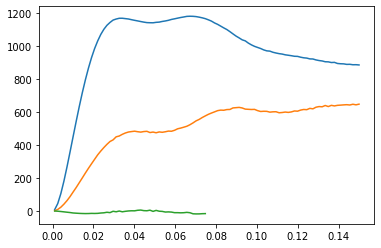

In [245]:
zp =  1.51         # zp
ap_perp = 1    # alpha_perp(zp)
ap_para = 1   # alpha_para(zp)
fps8 = 0.379         # f(zp)sigma8(zp)
gamma = 1        # gamma
b1s8 = 0.826         # b1(zp)sigma8(zp)
b2s8 = 0.426         # b2(zp)sigma8(zp)
s8 = 0.376          # sigma8(zp)
vp = 3.784            # sigma_v(zp) 
Nshot = -1580

z = 1.944
p0 = p(0,kk,z,
         zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot) 

p2 = p(2,kk,z,
         zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot) 
p4 = p(4,kk,z,
         zp,ap_perp,ap_para,fps8,gamma,b1s8,b2s8,s8,vp,Nshot) 

plt.plot(kk,kk*p0)
plt.plot(kk,kk*p2)
plt.plot(kk[:len(kk)//2],(kk*p4)[:len(kk)//2])